MIMIC III Visualizations
AI 395T - AI in Healthcare - Dr. Ying Ding

Joseph Skrovan,  2/3/2025

Some code was produced by ChatGPT. No MIMIC III data was sent to ChatGPT.

This works on a local copy of the MIMIC III dataset in this directory:
./mimic-iii-clinical-database-1.4/

To generate two derived tables run:
     python3 measurements.py - < weight.height.yaml
     python3 measurements.py - < a1c.yaml

In [3]:
#from google.colab import files
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Load patients data
#d1 = files.upload()
db_dir = 'mimic-iii-clinical-database-1.4'
patients = pd.read_csv(f'{db_dir}/PATIENTS.csv.gz')
admissions = pd.read_csv(f'{db_dir}/ADMISSIONS.csv.gz')
diagnoses = pd.read_csv(f'{db_dir}/DIAGNOSES_ICD.csv.gz')
diagnoses_labels = pd.read_csv(f'{db_dir}/D_ICD_DIAGNOSES.csv.gz')
# The next two files are derived from CHARTEVENTS.csv.gz and LABEVENTS.csv.gz respectively.
# They can be generated by running these commands:
#     python3 measurements.py - < weight.height.yaml
#     python3 measurements.py - < a1c.yaml
weight_height = pd.read_csv(f'{db_dir}/WEIGHT.HEIGHT.csv.gz')
a1c = pd.read_csv(f'{db_dir}/HEMOGLOBIN_A1C.csv.gz')
# Merge admissions and patients data on subject_id
df = pd.merge(admissions, patients, on="SUBJECT_ID")
df = pd.merge(df, diagnoses, on="HADM_ID")

print(df.shape)


(651047, 30)


## Patients Table

In [5]:
from datetime import datetime

# Calculate age at admission function
def calculate_age(dob, doa):
    if pd.isna(dob) or pd.isna(doa):
        return None
    dob_date = datetime.strptime(dob, "%Y-%m-%d %H:%M:%S")
    doa_date = datetime.strptime(doa, "%Y-%m-%d %H:%M:%S")
    age = (doa_date - dob_date).days // 365
    return int(age)

df["age"] = df.apply(lambda row: calculate_age(row["DOB"], row["ADMITTIME"]), axis=1)
df["survived"] = df.apply(lambda row: 1 if pd.isna(row["DEATHTIME"]) else 0, axis=1)
 
# Filter rows to ages 20 to 99
df = df[(df["age"] < 100) & (df["age"] > 19)]

print(df.shape)

(567096, 32)


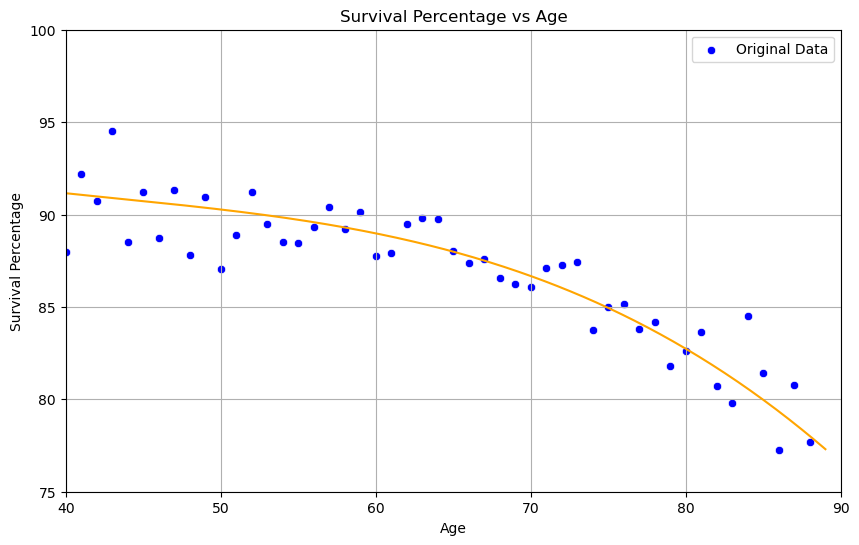

In [6]:
# Calculate survival percentage for each age
survival_percentage = df.groupby("age")["survived"].mean() * 100

def smooth(x, y):
    # Fit a polynomial curve for smoothing (degree 3)
    mask = ~np.isnan(y)  # Mask to avoid fitting NaN values
    if mask.sum() < 2:  # Ensure enough points for fitting
        return x, y
    coefficients = np.polyfit(x[mask], y[mask], deg=3)
    polynomial = np.poly1d(coefficients)
    
    # Generate smoothed points for plotting
    x_smooth = np.linspace(x.min(), x.max(), 500)
    y_smooth = polynomial(x_smooth)
    return x_smooth, y_smooth

x, y = survival_percentage.index, survival_percentage.values
x_smooth, y_smooth = smooth(x, y)

# Plot the smoothed curve
plt.figure(figsize=(10, 6))
sns.lineplot(x=x_smooth, y=y_smooth, color="orange")
sns.scatterplot(x=x, y=y, color="blue", label="Original Data")
plt.xlim(40, 90)
plt.ylim(75, 100)
plt.xlabel("Age")
plt.ylabel("Survival Percentage")
plt.title("Survival Percentage vs Age")
plt.grid(True)
plt.legend()
plt.show()

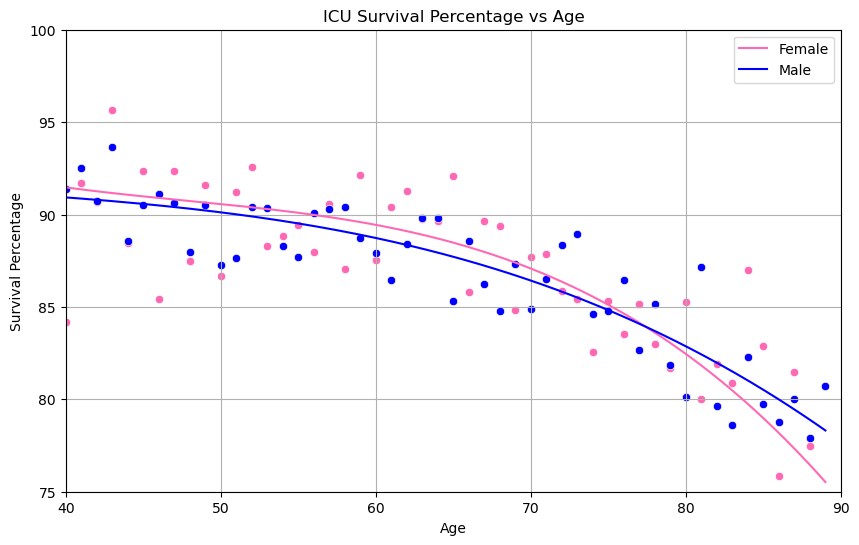

In [7]:
# Calculate survival percentage for each age
#survival_percentage = df.groupby("age")["survived"].mean() * 100
plt.figure(figsize=(10, 6))
plt.xlim(40, 90)
plt.ylim(75, 100)
#deeppink = '#FF1493'
deeppink = '#FF69B4'
for gender in ('F', 'M'):
    if gender == 'F':
        color = deeppink
        label = 'Female'
    else:
        color = 'blue'
        label = 'Male'

    survival_percentage = df[df["GENDER"] == gender].groupby("age")["survived"].mean() * 100
    x, y = survival_percentage.index, survival_percentage.values
    x_smooth, y_smooth = smooth(x, y)
    # Plot the smoothed curve
    sns.lineplot(x=x_smooth, y=y_smooth, color=color, label=label)
    sns.scatterplot(x=x, y=y, color=color)
plt.xlabel("Age")
plt.ylabel("Survival Percentage")
plt.title("ICU Survival Percentage vs Age")
plt.grid(True)
plt.legend()
plt.show()

In [8]:
# Convert the DataFrame to a dictionary to link icd9 codes to respective labels
icd9_labels = diagnoses_labels.set_index('ICD9_CODE')['SHORT_TITLE'].to_dict()

# Get the 5 most common icd9_codes and their counts
most_common_icd9_codes = df['ICD9_CODE'].value_counts().head(5)
# Print the 5 most common icd9_codes, their labels, and counts
for code, count in most_common_icd9_codes.items():
    label = icd9_labels.get(code, 'Unknown')
    print(f"ICD9 Code: {code}, Label: {label}, Count: {count}")

ICD9 Code: 4019, Label: Hypertension NOS, Count: 19473
ICD9 Code: 4280, Label: CHF NOS, Count: 11829
ICD9 Code: 41401, Label: Crnry athrscl natve vssl, Count: 11730
ICD9 Code: 42731, Label: Atrial fibrillation, Count: 11653
ICD9 Code: 25000, Label: DMII wo cmp nt st uncntr, Count: 8603


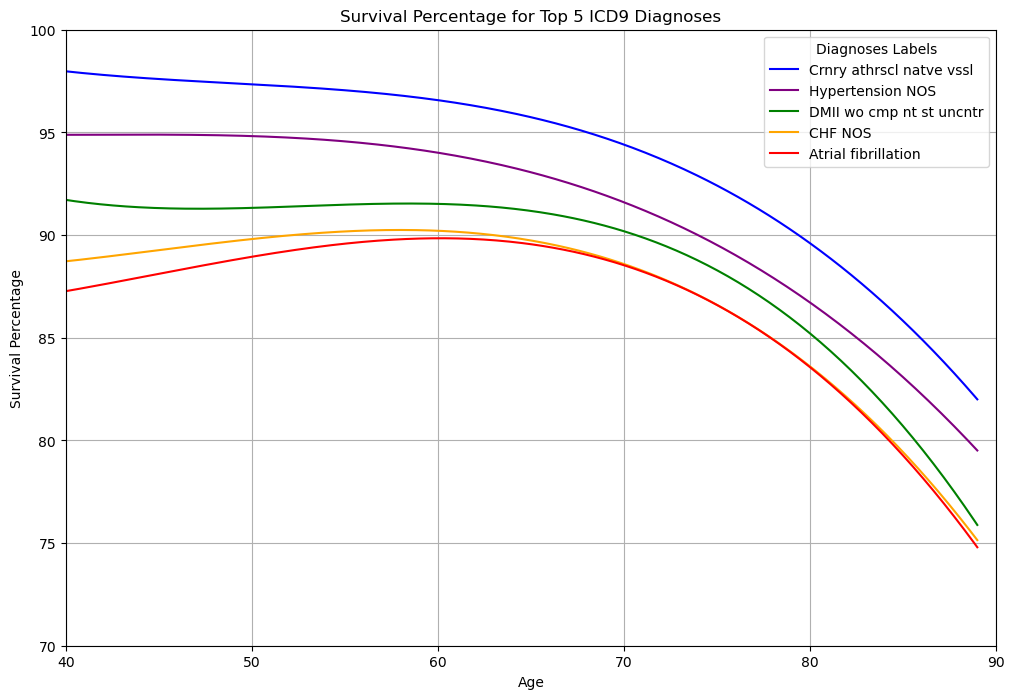

In [9]:
# Convert the DataFrame to a dictionary to link icd9 codes to respective labels
icd9_labels = diagnoses_labels.set_index('ICD9_CODE')['SHORT_TITLE'].to_dict()

# Get the top 5 most common diagnoses codes
top_icd9_codes = most_common_icd9_codes.index[:5]

# Filter the DataFrame for the diagnoses
filtered_df_top_icd9 = df[df['ICD9_CODE'].isin(top_icd9_codes)]

# Calculate survival percentage for each age and ICD9 code
survival_percentage_icd9 = (
    filtered_df_top_icd9.groupby(['age', 'ICD9_CODE'])['survived'].mean().unstack() * 100
)

# Define the full age range for interpolation
full_age_range = range(filtered_df_top_icd9['age'].min(), filtered_df_top_icd9['age'].max() + 1)

# Interpolate missing values for each ICD9 code to handle gaps
survival_percentage_icd9 = survival_percentage_icd9.reindex(full_age_range).interpolate()

# Plot survival percentage vs age for each of the top 5 ICD9 diagnoses codes
plt.figure(figsize=(12, 8))
colors = ['blue', 'purple', 'green', 'orange', 'red']
icd9_codes = [
    (top_icd9_codes[2], 'blue'),
    (top_icd9_codes[0], 'purple'),
    (top_icd9_codes[4], 'green'),
    (top_icd9_codes[1], 'orange'),
    (top_icd9_codes[3], 'red'),
]

for icd9_code, color in icd9_codes:
    label = icd9_labels[icd9_code]
    x, y = survival_percentage_icd9.index, survival_percentage_icd9[icd9_code].values
    x_smooth, y_smooth = smooth(x, y)
    
    # Plot the smoothed curve
    sns.lineplot(x=x_smooth, y=y_smooth, label=label, color=color)

# Set plot limits and labels
plt.xlim(40, 90)
plt.ylim(70, 100)
plt.xlabel("Age")
plt.ylabel("Survival Percentage")
plt.title("Survival Percentage for Top 5 ICD9 Diagnoses")
plt.legend(title="Diagnoses Labels")
plt.grid(True)
plt.show()


In [10]:
admissions_a1c_df = pd.merge(df, a1c, on="HADM_ID", how="inner")

/var/folders/7k/thvp7jdd0k1fjgvffpsvbjtr0000gp/T/ipykernel_8576/2995615159.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = admissions_a1c_df.groupby('age_group')['HEMOGLOBIN_A1C']


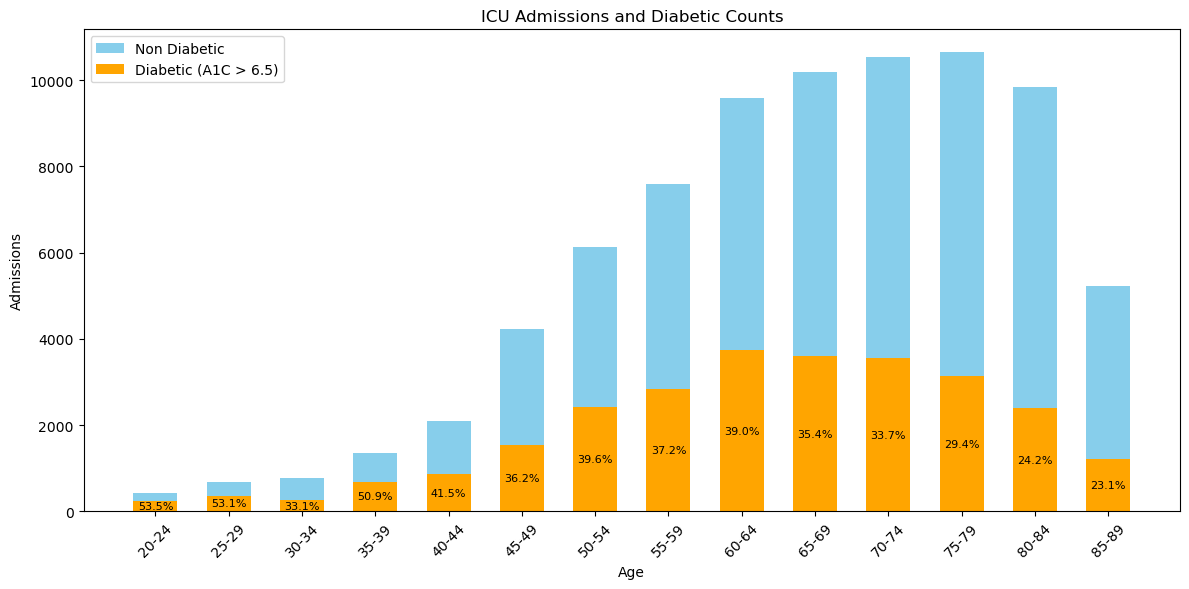

In [11]:
# Define 5-year age groups
bins = list(range(20, 91, 5))
labels = [f'{bins[i]}-{bins[i + 1] - 1}' for i in range(len(bins) - 1)]
admissions_a1c_df['age_group'] = pd.cut(admissions_a1c_df['age'], bins=bins, labels=labels, right=False)

# Group by age range and calculate the required statistics
grouped = admissions_a1c_df.groupby('age_group')['HEMOGLOBIN_A1C']
total_counts = grouped.size()
high_a1c_counts = grouped.apply(lambda x: (x > 6.5).sum())

# Prepare the data for plotting
age_ranges = total_counts.index
total_counts_values = total_counts.values
high_a1c_values = high_a1c_counts.values
percent_high_a1c = (high_a1c_values / total_counts_values) * 100

# Create the bar chart
plt.figure(figsize=(12, 6))
bar_width = 0.6
plt.bar(age_ranges, total_counts_values, color='skyblue', label='Non Diabetic', width=bar_width)
plt.bar(age_ranges, high_a1c_values, color='orange', label='Diabetic (A1C > 6.5)', width=bar_width)

for i in range(len(age_ranges)):  # Add percentages inside the high A1C bars
    plt.text(
        i,
        high_a1c_values[i] / 2,
        f'{percent_high_a1c[i]:.1f}%',
        ha='center',
        va='center',
        fontsize=8,
    )
plt.xlabel('Age')
plt.ylabel('Admissions')
plt.title('ICU Admissions and Diabetic Counts')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
bmi_df = pd.merge(df, weight_height, on="HADM_ID")
bmi_df["bmi"] = bmi_df["WEIGHT"] / (bmi_df["HEIGHT"] / 39.37) ** 2
bmi_df = bmi_df[(bmi_df["bmi"] > 10) & (bmi_df["bmi"] < 60)]

/var/folders/7k/thvp7jdd0k1fjgvffpsvbjtr0000gp/T/ipykernel_8576/3516874891.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')        # Backfill if NaNs are at the start
/var/folders/7k/thvp7jdd0k1fjgvffpsvbjtr0000gp/T/ipykernel_8576/3516874891.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')        # Forward fill if NaNs are at the end
/var/folders/7k/thvp7jdd0k1fjgvffpsvbjtr0000gp/T/ipykernel_8576/3516874891.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='GENDER', y='age', data=expanded_df, width=1, palette=gender_colors)


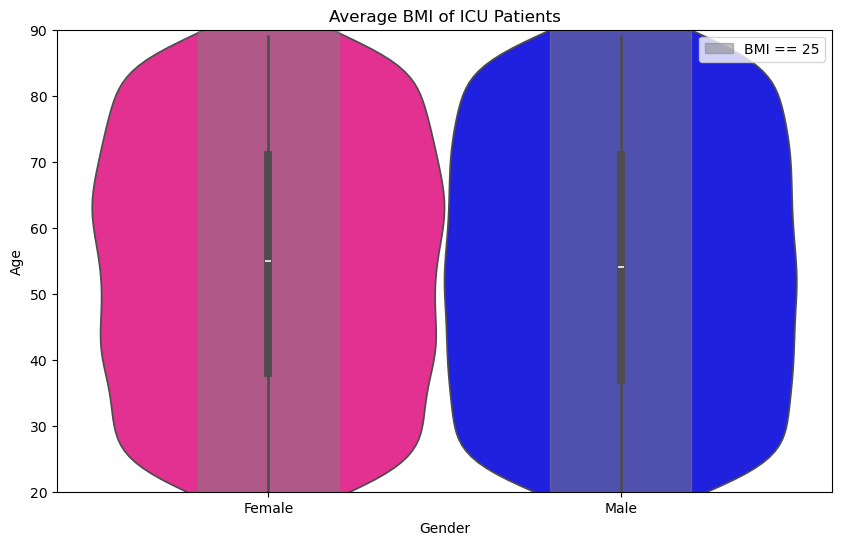

In [13]:
# Calculate BMI and group by 'age' and 'GENDER'
average_bmi_df = bmi_df.groupby(['age', 'GENDER'], as_index=False)['bmi'].mean()
average_bmi_df.rename(columns={'bmi': 'average_bmi'}, inplace=True)

# Fill missing values using interpolation
average_bmi_df['average_bmi'] = (
    average_bmi_df['average_bmi']
    .interpolate(method='linear')  # Interpolate missing values
    .fillna(method='bfill')        # Backfill if NaNs are at the start
    .fillna(method='ffill')        # Forward fill if NaNs are at the end
)

# Duplicate rows based on the average_bmi value (for the violin plot.)
expanded_df = average_bmi_df.loc[
    average_bmi_df.index.repeat(average_bmi_df['average_bmi'].round().astype(int))
]

# Define the healthy BMI upper limit
normal_bmi_upper = 25
violin_width = 0.8  # Width of the violin plot as a fraction of one unit on the x-axis
bmi_bar_width = (normal_bmi_upper / 50) * violin_width  # Scale the bar width proportionally

gender_colors = {'M': 'blue', 'F': 'deeppink'}
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='GENDER', y='age', data=expanded_df, width=1, palette=gender_colors)

# Add vertical spans representing the normal BMI range
for pos in [0, 1]:  # Positions for female and male plots
    plt.axvspan(  # Create a vertical span centered on each violin
        pos - (bmi_bar_width / 2),        # Start of the span
        pos + (bmi_bar_width / 2),        # End of the span
        ymin=0,                             
        ymax=1,                           # Full height of the plot
        color='gray',                     # Bar color
        alpha=0.5,                        # Transparency
        label=f'BMI == {normal_bmi_upper}' if pos == 0 else None  # Add label for the legend only once
    )

plt.title('Average BMI of ICU Patients')
plt.xlabel('Gender')
plt.ylabel('Age')
plt.ylim(20, 90)
plt.xticks([0, 1], ['Female', 'Male'])
plt.legend(loc='best')
plt.show()

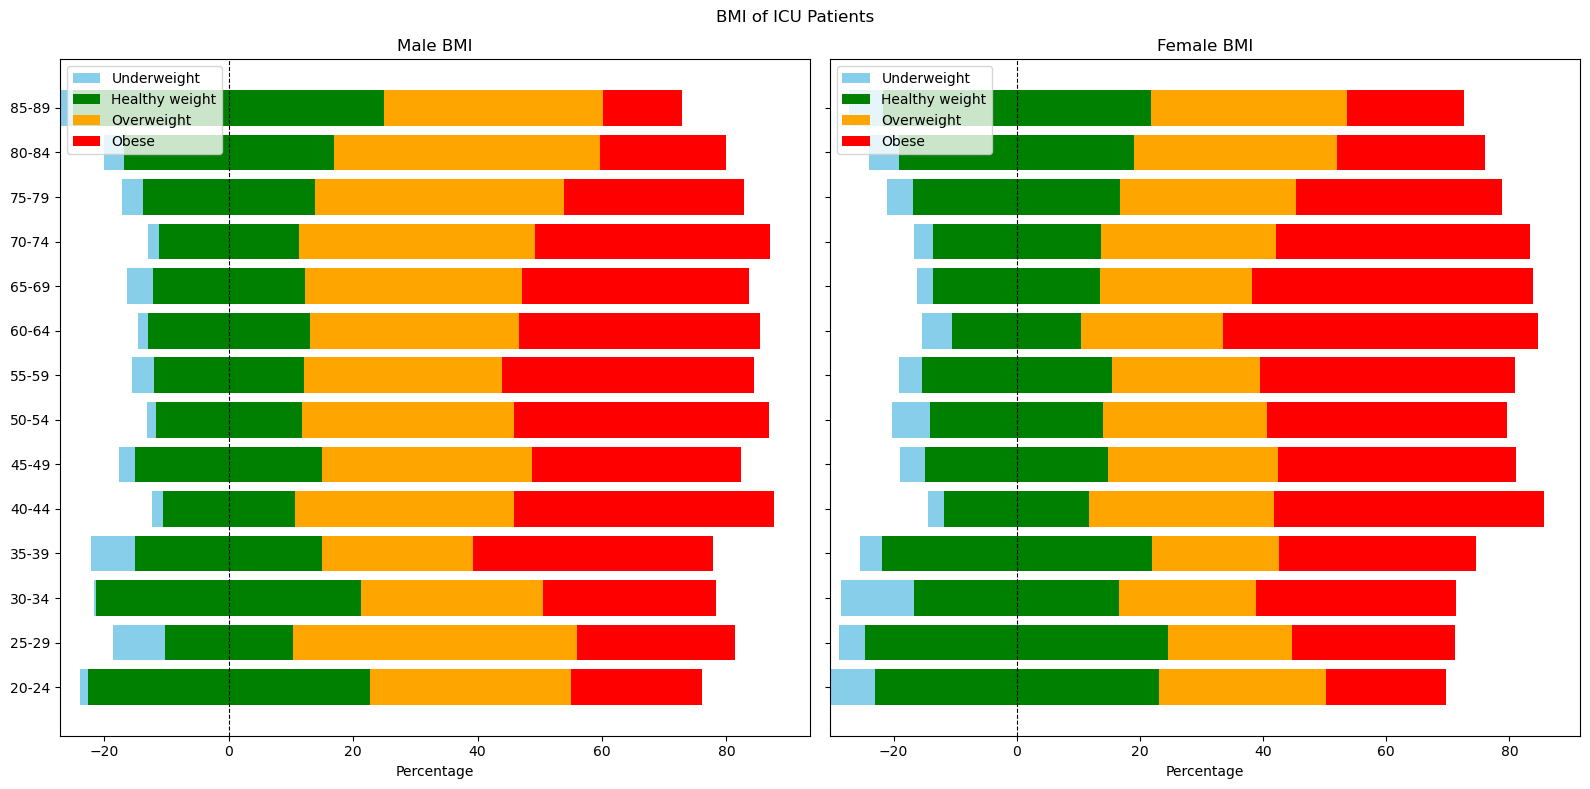

In [14]:
# Define BMI categories (adjust as needed)
def bmi_category(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif 18.5 <= bmi < 25:
        return 'normal'
    elif 25 <= bmi < 30:
        return 'overweight'
    else:
        return 'obese'

# Apply BMI categorization
bmi_bars_df = bmi_df.copy()
bmi_bars_df['bmi_category'] = bmi_bars_df['bmi'].apply(bmi_category)

# Create 5-year age groups
bmi_bars_df['age_group'] = (bmi_bars_df['age'] // 5) * 5  # Groups like 20-24, 25-29, etc.

# Calculate percentages for each category by age group and gender
grouped = bmi_bars_df.groupby(['age_group', 'GENDER', 'bmi_category']).size().reset_index(name='count')
total_counts = bmi_bars_df.groupby(['age_group', 'GENDER']).size().reset_index(name='total')
percentages = pd.merge(grouped, total_counts, on=['age_group', 'GENDER'])
percentages['percentage'] = (percentages['count'] / percentages['total']) * 100

# Pivot to get separate columns for categories and genders
plot_data = percentages.pivot_table(
    index='age_group', columns=['GENDER', 'bmi_category'], values='percentage', fill_value=0
)

# --- Plotting Centered Bar Plots ---
def plot_centered_bars(gender, ax):
    age_groups = plot_data.index
    underweight = plot_data[(gender, 'underweight')].fillna(0)
    normal = plot_data[(gender, 'normal')].fillna(0)
    overweight = plot_data[(gender, 'overweight')].fillna(0)
    obese = plot_data[(gender, 'obese')].fillna(0)

    for i, age_group in enumerate(age_groups):
        # Calculate bar positions centered on the "normal" category
        left_underweight = -underweight[age_group] - normal[age_group] / 2
        left_normal = left_underweight + underweight[age_group]
        left_overweight = left_normal + normal[age_group]
        left_obese = left_overweight + overweight[age_group]

        # Plot the horizontal bars
        ax.barh(i, underweight[age_group], color='skyblue', left=left_underweight, label='Underweight' if i == 0 else "")
        ax.barh(i, normal[age_group], color='green', left=left_normal, label='Healthy weight' if i == 0 else "")
        ax.barh(i, overweight[age_group], color='orange', left=left_overweight, label='Overweight' if i == 0 else "")
        ax.barh(i, obese[age_group], color='red', left=left_obese, label='Obese' if i == 0 else "")

    # Set axis labels and ticks
    ax.set_yticks(range(len(age_groups)))
    ax.set_yticklabels([f'{age_group}-{age_group + 4}' for age_group in age_groups])
    ax.set_xlabel('Percentage')
    full_gender = 'Male' if gender=='M' else 'Female'
    ax.set_title(f'{full_gender} BMI')
    ax.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Center line
    ax.legend(loc='upper left')

# Create plots for both genders
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot for males and females
plot_centered_bars('M', axes[0])
plot_centered_bars('F', axes[1])

# Final plot adjustments
plt.suptitle('BMI of ICU Patients')
plt.tight_layout()
plt.show()


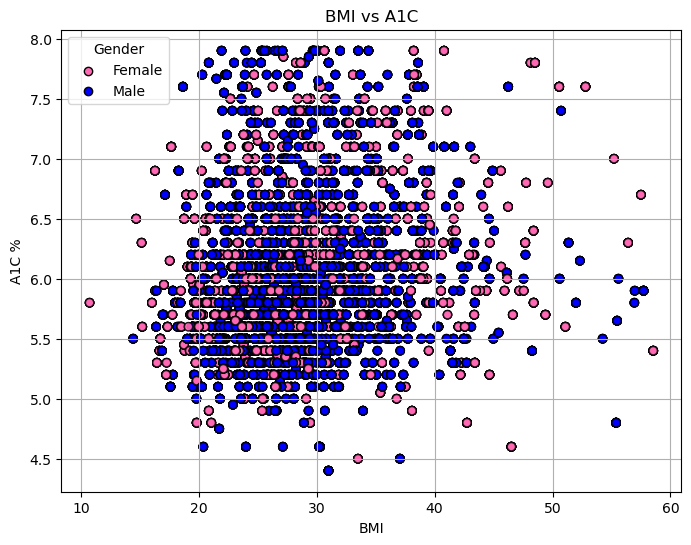

In [15]:
glucose_df = pd.merge(df, weight_height, on="HADM_ID", how="inner")
glucose_df = pd.merge(glucose_df, a1c, on="HADM_ID", how="inner")
glucose_df["bmi"] = glucose_df["WEIGHT"] / (glucose_df["HEIGHT"] / 39.37) ** 2
glucose_df = glucose_df[(glucose_df["HEMOGLOBIN_A1C"] < 8)]
glucose_df = glucose_df[(glucose_df["bmi"] > 10) & (glucose_df["bmi"] < 60)]

plt.figure(figsize=(8, 6))
dot_colors = glucose_df['GENDER'].apply(lambda x: deeppink if x == 'F' else 'blue')
plt.scatter(glucose_df['bmi'], glucose_df['HEMOGLOBIN_A1C'], alpha=0.7,
            c=dot_colors, edgecolors='k')

# Add labels and title
plt.xlabel('BMI')
plt.ylabel('A1C %')
plt.title('BMI vs A1C')

# Add legend
plt.scatter([], [], color=deeppink, label='Female', edgecolor='k')
plt.scatter([], [], color='blue', label='Male', edgecolor='k')
plt.legend(title='Gender', loc='best')

# Display the plot
plt.grid(True)
plt.show()